# Think of a title

write a description

In [1]:
using PorousMaterials
using LightGraphs
using GraphPlot
using Printf

In [2]:
@eval PorousMaterials PATH_TO_CRYSTALS = pwd()

"/home/ng/Documents/Graduate_Research/Cory_Simon/DTRA"

In [3]:
# open minimal framework
framework = Framework("NiPyC2.cif", convert_to_p1=false)
strip_numbers_from_atom_labels!(framework)
write_xyz(framework)

# for bonds
# a quick google search says Ni-N is ~2.065Å  
bonding_rules = [BondingRule(:H, :*, 0.4, 1.2),
                 BondingRule(:N, :Ni, 0.4, 2.5),
                 BondingRule(:O, :Ni, 0.4, 2.5),
                 BondingRule(:*, :*, 0.4, 1.9)]

infer_bonds!(framework, true, bonding_rules) 
write_bond_information(framework, "NiPyC2_bonds.vtk")
bond_sanity_check(framework)

Saving bond information for framework NiPyC2.cif to /home/ng/Documents/Graduate_Research/Cory_Simon/DTRA/NiPyC2_bonds.vtk.


true

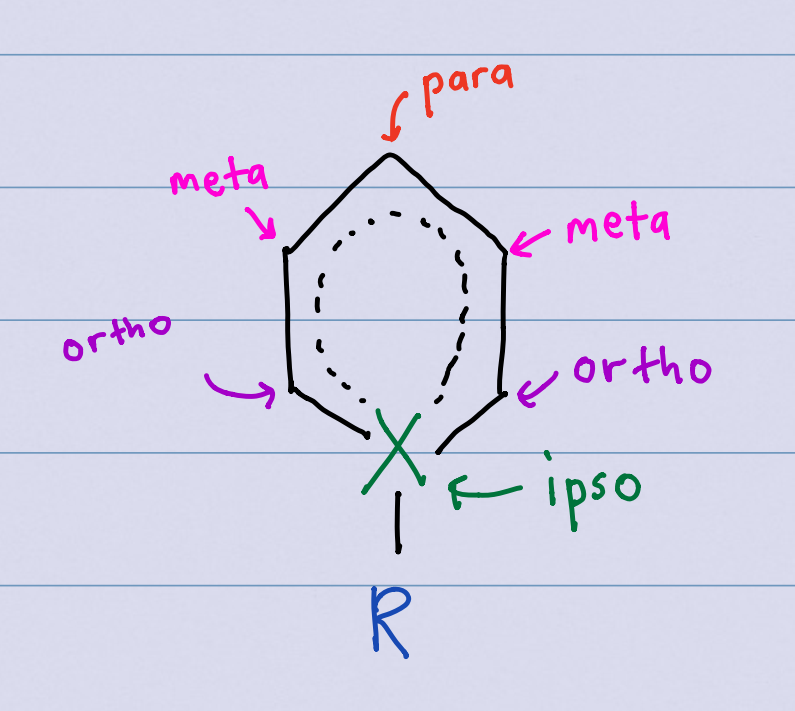

## Identify and Label Aromatic Rings 

In [4]:
# define the structure of the aromatic rings
mutable struct AromaticRing
    ipso::Int
    c_ortho::Array{Int, 1}
    h_ortho::Array{Int, 1}
    c_meta::Array{Int, 1}
    h_meta::Array{Int, 1}
    c_para::Int
end

In [5]:
empty_ring = AromaticRing(-1,[-1,-1],[-1,-1],[-1,-1],[-1,-1],-1) # default values?

AromaticRing(-1, [-1, -1], [-1, -1], [-1, -1], [-1, -1], -1)

In [6]:
# function find_aromatic_rings(functional_group::Symbol, ipso::Symbol)
# end

"""
given the R-atom and ipso atom, identify aromatic rings in the structure and populate the ipso field.
returns an array of AromaticRings
"""
function identify_rings(framework::Framework, r_species::Symbol, ipso_species::Symbol)
    ###
    #   identify ipso atoms, which are:
    #      (i) of species `ipso_species` and
    #      (ii) connected to an atom of species `r_species`
    ###
    all_ids = [i for i = 1:framework.atoms.n_atoms]
    ids_ipso = filter(id -> (framework.atoms.species[id] == ipso_species) 
        && (r_species in framework.atoms.species[neighbors(framework.bonds, id)]), all_ids)
    rings = [AromaticRing(id_ipso, [-1, -1], [-1, -1], [-1, -1], [-1, -1], -1) for id_ipso in ids_ipso]
    
    # Now we now have a list of rings with ipso attribute populated
    ###
    #   identify ortho carbons
    for kk in 1:length(rings)
        ids_c_ortho = filter(id_c_ortho -> ((framework.atoms.species[id_c_ortho] == :C)
                && (rings[kk].ipso in neighbors(framework.bonds, id_c_ortho))), all_ids)
        rings[kk].c_ortho = ids_c_ortho
    end
    

    for kk in 1:length(rings)
        for jj in 1:length(rings[kk].c_ortho)
     ### find the assosiated H atoms the ortho carbons       
            ids_h_ortho = filter(id_h_ortho -> ((framework.atoms.species[id_h_ortho] == :H) 
                    && (id_h_ortho in neighbors(framework.bonds, rings[kk].c_ortho[jj]))), all_ids)
            @assert length(ids_h_ortho) == 1
            rings[kk].h_ortho[jj] = ids_h_ortho[1]

     ### identify meta carbons and hydrogens connected to them
            ids_c_meta = filter(id_c_m -> ((framework.atoms.species[id_c_m] == :C) 
                    && (id_c_m in neighbors(framework.bonds, rings[kk].c_ortho[jj]))
                    && (rings[kk].ipso != id_c_m)), all_ids)
#             ids_c_meta = filter(meta -> ((rings[kk].ipso != ids_c_meta[meta]) for meta in ids_c_meta), ids_c_meta)
            @assert length(ids_c_meta)==1
            rings[kk].c_meta[jj] = ids_c_meta[1]

            ids_h_meta = filter(id_h_meta -> ((framework.atoms.species[id_h_meta] == :H) 
                    && (id_h_meta in neighbors(framework.bonds, rings[kk].c_meta[jj]))), all_ids)
            @assert length(ids_h_meta) == 1
            rings[kk].h_meta[jj] = ids_h_meta[1]
        end
    end
    
    ### 
    #   identify para carbon for each ring
    ###
    for kk in 1:length(rings)
        ids_para = filter(id_para -> ((id_para in neighbors(framework.bonds,rings[kk].c_meta[1])) && (id_para in neighbors(framework.bonds, rings[kk].c_meta[2]))),
            all_ids)
        @assert length(ids_para) == 1
        @assert framework.atoms.species[ids_para[1]] == :C
        rings[kk].c_para = ids_para[1]
    end
    
    
    ###
    #  run sanity checks (tons of assert statements).
    # for example, the number of ortho carbons should be twice as large as the number of ipso atoms.
    ###
    
    
    return rings
end

identify_rings

In [7]:
rings = identify_rings(framework, :Ni, :N)
print(rings[1],"\n")
print(rings[2])

AromaticRing(6, [17, 19], [18, 20], [8, 11], [9, 12], 10)
AromaticRing(7, [15, 21], [16, 22], [13, 23], [14, 24], 25)

In [8]:
# this plot isn't great, but it is a reasonable way to visually check that the rings and bonds are correct
# gplot(framework.bonds, nodelabel=1:framework.atoms.n_atoms)

In [9]:
# # iterate thru grpahs and print out all of the bonds
# for ed in edges(framework.bonds)
#     @printf("bond between atom %d (%s) and atom %d (%s)\n",
#         ed.src,
#         framework.atoms.species[ed.src],
#         ed.dst,
#         framework.atoms.species[ed.dst])
# end

In [10]:
f = Framework("SBMOF-1.cif", convert_to_p1=false, wrap_to_unit_cell=false)
strip_numbers_from_atom_labels!(f)

bonding = [BondingRule(:H, :*, 0.4, 1.2),
            BondingRule(:Ca, :O, 0.4, 2.5),
            BondingRule(:*, :*, 0.4, 1.9)]

infer_bonds!(f,true, bonding)
write_xyz(f)
write_bond_information(f, "SBMOF-1_bonds.vtk")
bond_sanity_check(f)

Saving bond information for framework SBMOF-1.cif to /home/ng/Documents/Graduate_Research/Cory_Simon/DTRA/SBMOF-1_bonds.vtk.


true

In [11]:
SB_rings = identify_rings(f, :S, :C)

2-element Array{AromaticRing,1}:
 AromaticRing(11, [7, 9], [8, 10], [3, 5], [4, 6], 2)        
 AromaticRing(12, [13, 15], [14, 16], [17, 19], [18, 20], 21)

In [12]:
# gplot(f.bonds, nodelabel=1:f.atoms.n_atoms)

In [13]:
# # iterate thru grpahs and print out all of the bonds
# for ed in edges(f.bonds)
#     @printf("bond between atom %d (%s) and atom %d (%s)\n",
#         ed.src,
#         f.atoms.species[ed.src],
#         ed.dst,
#         f.atoms.species[ed.dst])
# end

In [14]:
# test to see that the identify_rings() function is correctly identifyiing and labeling the atoms on the MOFs

# test for NiPyC
framework.atoms.species[rings[1].c_ortho[1]] = :C_aro_ortho
framework.atoms.species[rings[1].c_meta[1]] = :C_aro_meta
write_xyz(framework, "Test_MOF_1.xyz")

# test for SBMOF-1
f.atoms.species[SB_rings[1].c_ortho[1]] = :C_aro_ortho
f.atoms.species[SB_rings[2].c_meta[2]] = :C_aro_meta
write_xyz(f, "Test_MOF_2.xyz")

## Read in and Construct Fragments

In [15]:
fragment_location = joinpath(pwd(),"functonal_linkers","PyC")

"/home/ng/Documents/Graduate_Research/Cory_Simon/DTRA/functonal_linkers/PyC"

In [16]:
filename = "PyC_F_meta.xyz"
atoms, x = read_xyz(joinpath(fragment_location,filename))

atoms = Atoms(length(atoms), atoms, x)
unit_cube = UnitCube()
charges = Charges(0, [0.0, 0.0], [0.0 0.0; 0.0 0.0; 0.0 0.0])

Charges(0, [0.0, 0.0], [0.0 0.0; 0.0 0.0; 0.0 0.0])

In [17]:
frame = Framework("fragment", unit_cube, atoms, charges)

Name: fragment
Bravais unit cell of a crystal.
	Unit cell angles α = 90.000000 deg. β = 90.000000 deg. γ = 90.000000 deg.
	Unit cell dimensions a = 1.000000 Å. b = 1.000000 Å, c = 1.000000 Å
	Volume of unit cell: 1.000000 Å³

Number of atoms = 13
Number of charges = 0
Chemical formula: Dict(:N => 1,:F => 1,:H => 3,:O => 2,:C => 6)
Space Group: P1
Symmetry Operations:
	'x, y, z'


In [18]:
mutable struct FunctionalizedRing
    ligand::String               # abriviation for the ligand
    functional_group::Symbol     # the functional group that will be substituted
    sub_type::String             # the Arene subsitution type: ortho, meta, para, all
    fragment::Bool               # is this a fragment of an aromatic ring or not
    ring::AromaticRing           # data stucture for the ring
end    

In [19]:
empty_fun_ring = FunctionalizedRing("",Symbol(""),"",false,empty_ring)

FunctionalizedRing("", Symbol(""), "", false, AromaticRing(-1, [-1, -1], [-1, -1], [-1, -1], [-1, -1], -1))

In [20]:
# function that takes in the functionalized ring struct and generates the file name to be read in
function construct_filename_from_ring(ring::FunctionalizedRing)
    filename = ring.ligand * "_" * String(ring.functional_group) * "_" * ring.sub_type
    if ring.fragment == true
        filename *= "_fragment.xyz"
    else
        filename *= ".xyz"
    end
    return filename
end

construct_filename_from_ring (generic function with 1 method)

### TODO:
- wrie a function that will read in a `.xyz` file for a functionalized aromatic ring (or fragment) and construct the struct `functionalized_ring`
- ask about the default values for charges=Charges(0, [0.0, 0.0], [0.0 0.0; 0.0 0.0; 0.0 0.0])

In [21]:
# read in file
filename = "PyC_F_meta.xyz"
# atoms, x = read_xyz(joinpath(fragment_location,filename))
   
# atoms = Atoms(length(atoms), atoms, x)
# unit_cube = UnitCube()
# charges = Charges(0, [0.0, 0.0], [0.0 0.0; 0.0 0.0; 0.0 0.0])

"PyC_F_meta.xyz"

In [39]:
"""
    funtionalized_ring = functionalized_ring_from_xyz(filename::String; box=UnitCube()::Box, 
        charges=Charges(0, [0.0, 0.0], [0.0 0.0; 0.0 0.0; 0.0 0.0])::Charges)

This function will take in a `.xyz` file for a functionalized aromatic ring or a fragment of the ring
and construct a FunctionalizedRing data structure. 

# Arguements
- `filename::String`: This is the name of the file containing the structure information 
of the functionalized aromatic ring. 
- `box::Box`: The box for the molecule used to construct the `Framework`. The default is the `Unitcube()`
- `charges::Charges`: The charges used to construct the `Framework`. The default is Charges(0, [0.0, 0.0], [0.0 0.0; 0.0 0.0; 0.0 0.0])

The filenaming convention is as follows: "Lignad _ FunctionalGroup _ SubstitutionType _ Fragment.xyz"

- Ligand = The name/abreviation of the organic linker

- FunctionalGroup = The element or molecule that is being substituted onto the ring

- SubstitutionType = The positoion of the substitution following the Arene substitution naming convention (https://en.wikipedia.org/wiki/Arene_substitution_pattern)

- Fragment = The flag used to determine if the file is for a fragment or not. If the file is not a fragment this portion is left out of the filename.

# Returns
- `functionalized_ring::FunctionalizedRing`

# Atributes
- `ligand::String`: The name/abriviation for the ligand
- `functional_group::Symbol`: The functional group that will be substituted
- `sub_type::String`: The Arene subsitution type: ortho, meta, para, all
- `fragment::Bool`: The flag to determine if this a fragment of an aromatic ring or not
- `ring::AromaticRing`: The data stucture for the ring
"""
function functionalized_ring_from_xyz(filename::String, r_species::Symbol, ipso_species::Symbol; 
        box=UnitCube()::Box, charges=Charges(0, [0.0, 0.0], [0.0 0.0; 0.0 0.0; 0.0 0.0])::Charges)
    
    name = split(filename,('_','.'))
    # make sure the file has the correct extension
    ext = name[end]
    if ext != "xyz"
        error("The file must be filename.xyz")
    end
    
    # start with an empty struct
    fun_ring = empty_fun_ring
    
    # construct FunctionalizedRing
    fun_ring.ligand = name[1]
    fun_ring.functional_group = name[2]
    fun_ring.sub_type = name[3]
    @assert fun_ring.sub_type in ["ortho", "meta", "para", "all"] "Check arene substitution type."
    
    if "fragment" in name
        fun_ring.fragment = true
    else
        fun_ring.fragment = false
    end
    
    # generate a framework from the file
    elements, x = read_xyz(joinpath(fragment_location, filename))
    atoms = Atoms(length(elements), elements, x)
    frame = Framework(fun_ring.ligand, box, atoms, charges)
    ### Should I infer bonds?
    
    if fun_ring.fragment == true
        print("is a fragment")
        # we want to construct a framework for the fragment and label it
#         framework = 
#         label_fragment(frame, r_species, ipso_species, fun_ring)
    elseif fun_ring.fragment == false
        print("is not a fragment")
        # construct AromaticRing
#         fun_ring.ring = identify_rings(frame, r_species, ipso_species)
    end
        
    return fun_ring
end

functionalized_ring_from_xyz

In [23]:
# ? functionalized_ring_from_xyz

In [24]:
# we need a function that takes in the information from the *_fragment.xyz and identifies the ipso, ortho, etc.
# so that the correct atoms are used when it is alligned 

function label_fragment(framework::Framework, r_species::Symbol, ipso_species::Symbol)
    # conditional statements
end

label_fragment (generic function with 1 method)

## Align Ring and Substitue Fragment

### TODO:
- Decide whether we are going to use Quaternions or Orthoginal Procrustes to do the alignment
- strip the Hydrogen off of the linker and replace it with the functional group